In [1]:
import os, sys, subprocess, fitsio
from collections import Counter

import numpy as np
from astropy.table import Table
from astropy.io import fits

import desimodel.io
import desimodel.focalplane
import desimodel.footprint
from desitarget.targetmask import desi_mask, obsconditions
import matplotlib.pyplot as plt
%matplotlib inline

**Learning goals**

In this notebook you will learn how to:

* Use observational data from DR7 to prepare it for fiberassign.
* Run fiberassign using the files generated above.
* Explore the outputs of fiberassign.

This notebook has been tested against `desi_environment` `master` on June 2019.

This notebook reuses code by S. Bailey https://github.com/desihub/tutorials/blob/master/FiberAssign.ipynb

In [2]:
workdir = os.getenv('SCRATCH') + '/desi/test/fiberassign_obs'
os.makedirs(workdir, exist_ok=True)
os.chdir(workdir)
outdir = workdir + '/output'
os.makedirs(outdir, exist_ok=True)

Paths and filenames with the observational data

In [3]:
paths = {"targets": "/project/projectdirs/desi/target/catalogs/dr7.1/PR372/", 
         "skies": "/project/projectdirs/desi/target/catalogs/dr7.1/0.22.0/", 
         "gfas": "/project/projectdirs/desi/target/catalogs/dr7.1/0.22.0/",
}

names = {"targets": "dr7.1-PR372.fits", "skies":"dr7.1-0.22.0.fits", "gfas": "dr7.1.fits"}

Some more files needed to run fiberassign

In [4]:
mtlfile = os.path.join(workdir, 'mtl.fits')
truthfile = os.path.join(workdir, 'truth.fits')
starfile = os.path.join(workdir, 'std.fits')
targetcutfile = os.path.join(workdir, 'targets.fits') 
skycutfile = os.path.join(workdir, 'sky.fits') 
targetfile = os.path.join(paths["targets"], "targets-{}".format(names["targets"]))
skyfile = os.path.join(paths["skies"], "skies-{}".format(names["skies"]))
gfafile = os.path.join(paths["gfas"], "gfas-{}".format(names["gfas"]))
tilefile = os.path.join(workdir, "tiles.fits")

In [5]:
# tile selection
program = "dark"

tiles = desimodel.io.load_tiles()
bright = tiles['PROGRAM']=='BRIGHT'
    
small = ((tiles['RA']>12) & (tiles['RA']<20) & (tiles['DEC']<1) & (tiles['DEC']>-1))

if program=="bright":
    Table(tiles[(bright)&(small)]).write(tilefile, overwrite=True)
else:
    Table(tiles[(~bright) & (small)]).write(tilefile, overwrite=True)

print("Wrote tiles to {}".format(tilefile))

Wrote tiles to /global/cscratch1/sd/sjbailey/desi/test/fiberassign_obs/tiles.fits


In [6]:
# target selection results
print('Started reading {}'.format(targetfile))
targetdata = fitsio.read(targetfile, 'TARGETS')
ii = (targetdata['RA']>10) &  (targetdata['RA']<22) & (targetdata['DEC']<3) & (targetdata['DEC']>-3)
targetdata = targetdata[ii]
print('Done reading target data to compute mtl + star')

Started reading /project/projectdirs/desi/target/catalogs/dr7.1/PR372/targets-dr7.1-PR372.fits
Done reading target data to compute mtl + star


Text(0,0.5,'DEC [deg]')

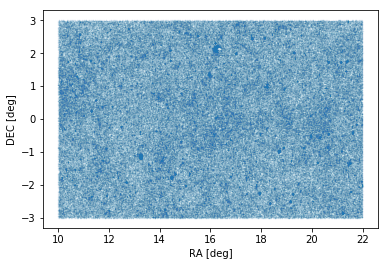

In [7]:
plt.scatter(targetdata['RA'], targetdata['DEC'],s=0.1, alpha=0.1)
plt.xlabel('RA [deg]')
plt.ylabel('DEC [deg]')

In [8]:
# write down the targets to disk

if (not os.path.exists(targetcutfile)):
    Table(targetdata).write(targetcutfile, overwrite=True)
    print('Done writing target cut data')

Done writing target cut data


In [9]:
# compute sky file
if (not os.path.exists(skycutfile)):
    skydata = fitsio.read(skyfile)
    ii = (skydata['RA']>10) &  (skydata['RA']<22) & (skydata['DEC']<3) & (skydata['DEC']>-3)
    jj = (skydata['DESI_TARGET'] & desi_mask.SKY)!=0
    skydata = skydata[ii&jj]
    Table(skydata).write(skycutfile, overwrite=True)
    print('Done writing sky cut data')
skydata = Table.read(skycutfile)

Done writing sky cut data


Text(0,0.5,'DEC [deg]')

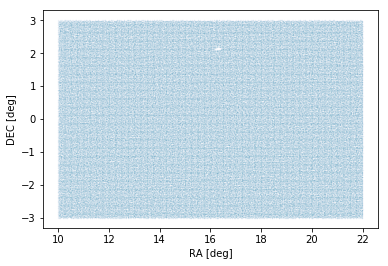

In [10]:
plt.scatter(skydata['RA'], skydata['DEC'],s=0.1, alpha=0.1)
plt.xlabel('RA [deg]')
plt.ylabel('DEC [deg]')

In [11]:
#standards
if not os.path.exists(starfile):
    std_mask = 0
    for name in ['STD', 'STD_FSTAR', 'STD_WD',
             'STD_FAINT', 'STD_FAINT_BEST',
             'STD_BRIGHT', 'STD_BRIGHT_BEST']:
        if name in desi_mask.names():
            std_mask |= desi_mask[name]

    starstd = (targetdata['DESI_TARGET'] & std_mask) != 0
    stardata = targetdata[starstd]

    if program=="bright":
        obscond = np.int_(np.repeat(obsconditions['BRIGHT'], len(stardata)))
    else:
        obscond = np.int_(np.repeat(obsconditions['DARK']|obsconditions['GRAY'], len(stardata))) 

    stardata = np.lib.recfunctions.append_fields(stardata, 'OBSCONDITIONS', obscond)  
        
    ii = (stardata['RA']>10) &  (stardata['RA']<22) & (stardata['DEC']<3) & (stardata['DEC']>-3)
    stardata = stardata[ii]
        
    fitsio.write(starfile, stardata, extname='STD')
    print('{} standards'.format(np.count_nonzero(stardata)))
    print('Finished with standards')
stardata = Table.read(starfile)

4678 standards
Finished with standards


Text(0,0.5,'DEC [deg]')

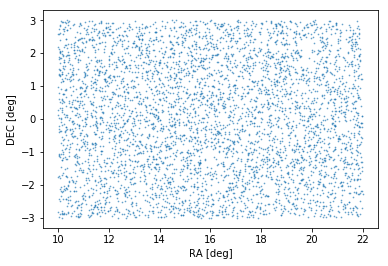

In [12]:
plt.scatter(stardata['RA'], stardata['DEC'],s=0.5, alpha=0.6)
plt.xlabel('RA [deg]')
plt.ylabel('DEC [deg]')

In [13]:
#compute MTL
if not os.path.exists(mtlfile):
    print('computing mtl')
    import desitarget.mtl
    mtl = desitarget.mtl.make_mtl(targetdata)

    # only include BGS and MWS
    isbgsmws = ((mtl['BGS_TARGET']!=0) | (mtl['MWS_TARGET']!=0))
    if program=="bright":
        mtl = mtl[isbgsmws]
    else:
        mtl = mtl[~isbgsmws]


    mtl.meta['EXTNAME'] = 'MTL'
    mtl.write(mtlfile)
    
    #print some stats
    print('MWS_TARGETS: {}'.format(np.count_nonzero(mtl['MWS_TARGET']!=0)))
    print('BGS_TARGETS: {}'.format(np.count_nonzero(mtl['BGS_TARGET']!=0)))
    print('DESI_TARGETS: {}'.format(np.count_nonzero(mtl['DESI_TARGET']!=0)))
    print('finished computing mtl')
mtl = Table.read(mtlfile)

computing mtl


TypeError: make_mtl() missing 1 required positional argument: 'obscon'

In [ ]:
plt.scatter(mtl['RA'], mtl['DEC'], s=0.1, alpha=0.1)
plt.xlabel('RA [deg]')
plt.ylabel('DEC [deg]')

In [ ]:
cmd = 'fiberassign --overwrite --mtl mtl.fits --stdstar std.fits --sky sky.fits'
cmd += ' --footprint ./tiles.fits'
cmd += ' --outdir ./output/'
cmd = cmd.format(outdir=outdir)
print(cmd)

In [ ]:
print('RUNNING: '+cmd)
err = subprocess.call(cmd.split())
print(err)
assert err == 0

In [ ]:
tiles = Table.read("tiles.fits")
targets = Table.read("mtl.fits")

In [ ]:
# Gather all outputs
assignments = list()
for tileid in tiles['TILEID']:
    tilefile = '{}/tile-{:06d}.fits'.format(outdir, tileid)
    assignments.append(Table.read(tilefile, hdu=1))
    
assigned_targetids = np.concatenate([tmp['TARGETID'] for tmp in assignments])
isAssigned = np.in1d(targets['TARGETID'], assigned_targetids)

plt.figure(figsize=(12,4))
plt.plot(targets['RA'][isAssigned], targets['DEC'][isAssigned], 'k,')
plt.title('Targets assigned to fibers')
plt.xlabel('RA [deg]')
plt.ylabel('DEC [deg]')

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(targets['RA'][~isAssigned], targets['DEC'][~isAssigned], 'k,')
plt.title('Targets left unassigned to fibers')
plt.xlabel('RA [deg]')
plt.ylabel('DEC [deg]')